# Capstone Project - The Battle of the Neighborhoods (Week 1)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Coffee Shop** in **Stockholm**, Sweden.

Since there are lots of restaurants in Stockholm we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no coffee shop in vicinity**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing coffee shop in the neighborhood (including restaurant offer coffee)
* number of and distance to other coffee shop in the neighborhood, if any
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of coffee shop and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Dhaka center will be obtained using **Google Maps API geocoding**

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 12x12 killometers centered around Berlin city center.

Let's first find the latitude & longitude of Berlin city center, using specific, well known address and Google Maps geocoding API.

In [34]:
#!pip install folium
import folium
#!pip install geopy
from geopy.geocoders import Nominatim
#!pip install shapely
#import shapely.geometry
#!pip install pyproj
import pyproj
import math
import json # library to handle JSON files
import requests
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#import beautiful soup
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
print('library added')

library added


In [35]:
address = 'Stockholm, Sweden'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
stockholm_center = [latitude, longitude]
print('The geograpical coordinate of ', address ,'are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of  Stockholm, Sweden are 59.3251172, 18.0710935.


Now let's create a grid of area candidates, equaly spaced, centered around city center and within ~6km from Stockholm. Our neighborhoods will be defined as circular areas with a radius of 300 meters, so our neighborhood centers will be 600 meters apart.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [36]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Stockholm center longitude={}, latitude={}'.format(stockholm_center[1], stockholm_center[0]))
x, y = lonlat_to_xy(stockholm_center[1], stockholm_center[0])
print('Stockholm center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Stockholm center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
Stockholm center longitude=18.0710935, latitude=59.3251172
Stockholm center UTM X=674735.1349179444, Y=6580284.089114029
Stockholm center longitude=18.0710935, latitude=59.3251172


In [37]:
stockholm_center_x, stockholm_center_y = lonlat_to_xy(stockholm_center[1], stockholm_center[0]) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = stockholm_center_x - 6000
x_step = 600
y_min = stockholm_center_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(stockholm_center_x, stockholm_center_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

364 candidate neighborhood centers generated.


Let's create a **hexagonal grid of cells**: we offset every other row, and adjust vertical row spacing so that **every cell center is equally distant from all it's neighbors**.

In [38]:
map_stockholm = folium.Map(location=stockholm_center, zoom_start=13)
folium.Marker(stockholm_center, popup='Stockholm').add_to(map_stockholm)
for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_stockholm)
    #folium.Marker([lat, lon]).add_to(map_berlin)
map_stockholm

Let's visualize the data we have so far: city center location and candidate neighborhood centers:

OK, we now have the coordinates of centers of neighborhoods/areas to be evaluated, equally spaced (distance from every point to it's neighbors is exactly the same) and within ~6km from Stortorget, Stockholm. 

Let's now use Google Maps API to get approximate addresses of those locations.

#### Entering in our information into the Foursquare API to access it.

In [39]:
CLIENT_ID = 'JA2RLBI4IPPSFTWAVNIXIOLLUVQCOHIB4AV0ZTEBSLZGE0GI' # your Foursquare ID
CLIENT_SECRET = 'IUE4XAZ1BIFVBZDALGNDY4HDW3IU1EDX4NAGN4F3OW4VWAE5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JA2RLBI4IPPSFTWAVNIXIOLLUVQCOHIB4AV0ZTEBSLZGE0GI
CLIENT_SECRET:IUE4XAZ1BIFVBZDALGNDY4HDW3IU1EDX4NAGN4F3OW4VWAE5


In [40]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=JA2RLBI4IPPSFTWAVNIXIOLLUVQCOHIB4AV0ZTEBSLZGE0GI&client_secret=IUE4XAZ1BIFVBZDALGNDY4HDW3IU1EDX4NAGN4F3OW4VWAE5&v=20180605&ll=59.3251172,18.0710935&radius=500&limit=100'

#### Result from Foursquare

In [41]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e8b4cf840a7ea001c5109f3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Storkyrkan',
  'headerFullLocation': 'Storkyrkan, Stockholm',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 90,
  'suggestedBounds': {'ne': {'lat': 59.3296172045, 'lng': 18.079897699230337},
   'sw': {'lat': 59.3206171955, 'lng': 18.062289300769663}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b06fe89f964a520fef422e3',
       'name': 'Science Fiction Bokhandeln',
       'location': {'address': 'Västerlånggatan 48',
        'crossStreet': 'Gamla Stan',
        'lat': 59.32404679408319,
        'lng': 18.070682162632647,
        'labeledLatLngs': [

#### Now we start pulling the data from Foursquare into a dataframe so we can manipulate and use it.

In [42]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [43]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Science Fiction Bokhandeln,4b06fe89f964a520fef422e3,Bookstore,59.324047,18.070682
1,Tweed,51434b65e4b00cf8d47795f1,Cocktail Bar,59.324471,18.067696
2,The Burgundy,522784bb11d2164a04286219,Wine Bar,59.324434,18.068161
3,Stortorget,4b0e3607f964a520fa5523e3,Plaza,59.324973,18.070727
4,Barrels Burgers & Beer,549447fb498ed7d33f190dc2,Burger Joint,59.324685,18.068513
...,...,...,...,...,...
85,Zum Franziskaners Bakfickan,5b8d00674b78c5002c45b22d,Beer Bar,59.322278,18.074248
86,Birger Jarls torg,4bd6ddee6f6495218a7071ec,Plaza,59.325062,18.063885
87,Fjäderholmslinjen,4c0a1d85a1b32d7fa2d098f0,Boat or Ferry,59.321796,18.075100
88,Djurgården 8,55c4abdf498ee9678989507c,Boat or Ferry,59.323895,18.078907


In [44]:
#fix the column names so they look relatively normal
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,Science Fiction Bokhandeln,4b06fe89f964a520fef422e3,Bookstore,59.324047,18.070682
1,Tweed,51434b65e4b00cf8d47795f1,Cocktail Bar,59.324471,18.067696
2,The Burgundy,522784bb11d2164a04286219,Wine Bar,59.324434,18.068161
3,Stortorget,4b0e3607f964a520fa5523e3,Plaza,59.324973,18.070727
4,Barrels Burgers & Beer,549447fb498ed7d33f190dc2,Burger Joint,59.324685,18.068513
...,...,...,...,...,...
85,Zum Franziskaners Bakfickan,5b8d00674b78c5002c45b22d,Beer Bar,59.322278,18.074248
86,Birger Jarls torg,4bd6ddee6f6495218a7071ec,Plaza,59.325062,18.063885
87,Fjäderholmslinjen,4c0a1d85a1b32d7fa2d098f0,Boat or Ferry,59.321796,18.075100
88,Djurgården 8,55c4abdf498ee9678989507c,Boat or Ferry,59.323895,18.078907


Looking good. Let's now place all this into a Pandas dataframe.

In [45]:
nearby_venues['categories'].unique()

array(['Bookstore', 'Cocktail Bar', 'Wine Bar', 'Plaza', 'Burger Joint',
       'Scandinavian Restaurant', 'Gastropub', 'Pub', 'Bakery', 'Palace',
       'Jazz Club', 'Historic Site', 'Mexican Restaurant', 'Comic Shop',
       'Theme Restaurant', 'Café', 'Record Shop', 'Polish Restaurant',
       'Tea Room', 'Noodle House', 'History Museum', 'Outdoor Sculpture',
       'Restaurant', 'Hostel', 'Bike Shop', 'Hotel', 'Italian Restaurant',
       'Irish Pub', 'Gift Shop', 'Fish & Chips Shop', 'Museum',
       'French Restaurant', 'Monument / Landmark', 'Coffee Shop', 'Bar',
       'Church', 'Seafood Restaurant', 'Art Museum', 'Opera House',
       'Park', 'Event Space', 'Boat or Ferry', 'Other Great Outdoors',
       'Building', 'Beer Bar', 'Moving Target'], dtype=object)

...and let's now save/persist this data into local file.

In [46]:
# creating a list of categorie to remove from our dataframe because they are not restaurants
# I am sure there is a function that can be written to do this at scale but since it was a small list, I did it manually

removal_list = ['Bookstore', 'Bakery', 'Jazz Club', "Bike Shop", 'Comic Shop', 'Plaza', 'Gastropub',
               'Record Shop', 'Pub', 'Pet Store', 'Historic Site', 'Outdoor Sculpture', 'Tea Room', 'History Museum', 'Irish Pub',
       'Hostel','Gift Shop','BBQ Joint','Toy / Game Store', 'Bar','Fish & Chips Shop','Hotel', 'Museum','Church', 'Candy Store', 'Art Museum', 'Opera House',
       'Monument / Landmark', 'Park', 'Breakfast Spot', 'Boat or Ferry',
       'Other Great Outdoors', 'Building']

nearby_venues2 = nearby_venues.copy()


#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2 

,name,id,categories,lat,lng
1,Tweed,51434b65e4b00cf8d47795f1,Cocktail Bar,59.324471,18.067696
2,The Burgundy,522784bb11d2164a04286219,Wine Bar,59.324434,18.068161
4,Barrels Burgers & Beer,549447fb498ed7d33f190dc2,Burger Joint,59.324685,18.068513
5,Tradition,534d0a34498ef782062ac89c,Scandinavian Restaurant,59.325940,18.073710
7,Slingerbulten,4ba0c261f964a520a77b37e3,Scandinavian Restaurant,59.324376,18.068967
8,Corner Club,514c0868e4b07a3d6af2fca3,Cocktail Bar,59.323342,18.069431
9,Pharmarium,51ccb742498e64f625f8ce57,Cocktail Bar,59.324851,18.070891
10,19 Glas Bar & Matsal,4b9a5e8ff964a52072af35e3,Wine Bar,59.324633,18.068670
13,Kungliga Slottet (Kungliga slottet),4adcdaeef964a520c95a21e3,Palace,59.326353,18.071140
14,AIFUR | krog & bar,4ece875cb634dd298f5ea304,Scandinavian Restaurant,59.323097,18.071993


#### Now let's get a list of venue ids so we can pull likes and add to our dataframe.

In [47]:
#let's get a list of venues

venue_id_list = nearby_venues2['id'].tolist()
venue_id_list

['51434b65e4b00cf8d47795f1',
 '522784bb11d2164a04286219',
 '549447fb498ed7d33f190dc2',
 '534d0a34498ef782062ac89c',
 '4ba0c261f964a520a77b37e3',
 '514c0868e4b07a3d6af2fca3',
 '51ccb742498e64f625f8ce57',
 '4b9a5e8ff964a52072af35e3',
 '4adcdaeef964a520c95a21e3',
 '4ece875cb634dd298f5ea304',
 '4c78322f93ef236a9772ab0f',
 '550867d7498e86f0d8c9a61d',
 '50c0cc79e4b0a80fdc3460df',
 '583875a96d632566864f820c',
 '4dc28371887770a6be00accd',
 '5729f110498e722233305953',
 '4b63079df964a520945e2ae3',
 '4adcdaedf964a520555a21e3',
 '58c90efcd243323eaf526efb',
 '4c63fd4479d1e21eacddd915',
 '4d381d443ffba143aed55856',
 '55df60fd498e44d120c585cb',
 '4adcdaebf964a520e35921e3',
 '4b7d9501f964a52014c82fe3',
 '4adcdaf0f964a520655b21e3',
 '51cb1bd3498e9a51850326c1',
 '4b4f5698f964a520f60127e3',
 '4b583319f964a520bf4d28e3',
 '4d567a4358856dcb5711586d',
 '4d66061b48ee6ea85d166168',
 '5cbb29e9e55d8b0038f9ef69',
 '4c62750486b6be9ae3138c34',
 '4f045c63754a4b3575c9c063',
 '4c779735923ba1434b6e67e6',
 '51829a91498e

In [48]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[199, 42, 453, 106, 138, 103, 181, 110, 511, 275, 121, 78, 71, 27, 33, 28, 148, 104, 16, 77, 109, 11, 226, 70, 116, 32, 37, 38, 9, 15, 6, 55, 9, 6, 153, 65, 21, 5, 7, 24, 32, 4, 0]


In [49]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

43
43


### Data Prep Intro
We thought likes are a proxy for quality. The more likes there are, the better the restaurant is. This might be incorrect but API call issues (how many I can use for free) holds me back from getting price / rating data. I will then bin this data into a quality categorical variables so we can cluster appropriately.

I am also going to create new categorical variables for the restaurants to better group them based on type of cuisine. This way you can look for good mexican food or now what type of food might be best to eat in Hoboken if you are new to the area.

### Data Prep Part 1
Now let's start prepping our data for clustering. This will include combining data from different lists, creating new categorical data to be used, binning data and then encoding the data for clustering.

In [50]:
#let's make a copy of our initial dataframe just in case anything goes wrong

stockholm_venues = nearby_venues2.copy()
stockholm_venues.head()

,name,id,categories,lat,lng
1,Tweed,51434b65e4b00cf8d47795f1,Cocktail Bar,59.324471,18.067696
2,The Burgundy,522784bb11d2164a04286219,Wine Bar,59.324434,18.068161
4,Barrels Burgers & Beer,549447fb498ed7d33f190dc2,Burger Joint,59.324685,18.068513
5,Tradition,534d0a34498ef782062ac89c,Scandinavian Restaurant,59.325940,18.073710
7,Slingerbulten,4ba0c261f964a520a77b37e3,Scandinavian Restaurant,59.324376,18.068967


### Data Prep Part 2

In [51]:
# add in the list of likes

stockholm_venues['total likes'] = like_list
stockholm_venues.head()

,name,id,categories,lat,lng,total likes
1,Tweed,51434b65e4b00cf8d47795f1,Cocktail Bar,59.324471,18.067696,199
2,The Burgundy,522784bb11d2164a04286219,Wine Bar,59.324434,18.068161,42
4,Barrels Burgers & Beer,549447fb498ed7d33f190dc2,Burger Joint,59.324685,18.068513,453
5,Tradition,534d0a34498ef782062ac89c,Scandinavian Restaurant,59.325940,18.073710,106
7,Slingerbulten,4ba0c261f964a520a77b37e3,Scandinavian Restaurant,59.324376,18.068967,138


### Data Prep Part 3

In [52]:
# now let's bin total likes

print(stockholm_venues['total likes'].max())
print(stockholm_venues['total likes'].min())
print(stockholm_venues['total likes'].median())
print(stockholm_venues['total likes'].mean())

511
0
55.0
90.02325581395348


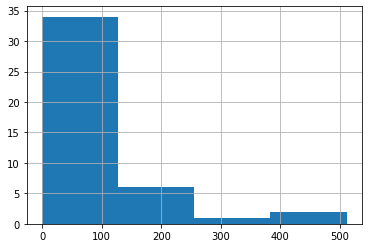

In [53]:
import matplotlib.pyplot as plt
stockholm_venues['total likes'].hist(bins=4)
plt.show()

In [54]:
# what are the bins we want to use?
print(np.percentile(stockholm_venues['total likes'], 25))
print(np.percentile(stockholm_venues['total likes'], 50))
print(np.percentile(stockholm_venues['total likes'], 75))

18.5
55.0
113.0


In [55]:
# now we have our bin values so let's set them to the appropriate values
# less than 24, 24-45, 45-76, 76>
# poor, below avg, abv avg, great

poor = stockholm_venues['total likes']<=24
below_avg = stockholm_venues[(stockholm_venues['total likes']>24) & (stockholm_venues['total likes']<=45)]
abv_avg = stockholm_venues[(stockholm_venues['total likes']>45) & (stockholm_venues['total likes']<=76)]
great = stockholm_venues['total likes']>76

In [56]:
stockholm_venues

,name,id,categories,lat,lng,total likes
1,Tweed,51434b65e4b00cf8d47795f1,Cocktail Bar,59.324471,18.067696,199
2,The Burgundy,522784bb11d2164a04286219,Wine Bar,59.324434,18.068161,42
4,Barrels Burgers & Beer,549447fb498ed7d33f190dc2,Burger Joint,59.324685,18.068513,453
5,Tradition,534d0a34498ef782062ac89c,Scandinavian Restaurant,59.325940,18.073710,106
7,Slingerbulten,4ba0c261f964a520a77b37e3,Scandinavian Restaurant,59.324376,18.068967,138
8,Corner Club,514c0868e4b07a3d6af2fca3,Cocktail Bar,59.323342,18.069431,103
9,Pharmarium,51ccb742498e64f625f8ce57,Cocktail Bar,59.324851,18.070891,181
10,19 Glas Bar & Matsal,4b9a5e8ff964a52072af35e3,Wine Bar,59.324633,18.068670,110
13,Kungliga Slottet (Kungliga slottet),4adcdaeef964a520c95a21e3,Palace,59.326353,18.071140,511
14,AIFUR | krog & bar,4ece875cb634dd298f5ea304,Scandinavian Restaurant,59.323097,18.071993,275


In [57]:
# let's star the process for re-categorizing the categories

stockholm_venues['categories'].unique()

array(['Cocktail Bar', 'Wine Bar', 'Burger Joint',
       'Scandinavian Restaurant', 'Palace', 'Mexican Restaurant',
       'Theme Restaurant', 'Café', 'Polish Restaurant', 'Noodle House',
       'Restaurant', 'Italian Restaurant', 'French Restaurant',
       'Coffee Shop', 'Seafood Restaurant', 'Event Space', 'Beer Bar',
       'Moving Target'], dtype=object)

In [59]:
# let's create our new categories and create a function to apply those to our existing data

bars = ['Pub', 'Cocktail Bar', 'Bar', 'Dive Bar', 'Sports Bar']
other = ['Bagel Shop', 'Tea Room', 'Donut Shop', 'Coffee Shop', 'Bubble Tea Shop', 'Sandwich Place', 'Boutique', 'Ice Cream Shop']
euro_asia_indian_food = ['Falafel Restaurant', 'Korean Restaurant','Sushi Restaurant', 'Indian Restaurant', 'Japanese Restaurant', 'Poke Place', 'Thai Restaurant', 'Vietnamese Restaurant']
mex_southam_food = ['Cuban Restaurant', 'Mexican Restaurant', 'South American Restaurant', 'Latin American Restaurant']
american_food = ['Burger Joint', 'Restaurant', 'American Restaurant']
italian_food = ['Italian Restaurant', 'Seafood Restaurant', 'Pizza Place']

def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in euro_asia_indian_food:
        return 'euro asia indian food'
    if s['categories'] in mex_southam_food:
        return 'mex southam food'
    if s['categories'] in american_food:
        return 'american food'
    if s['categories'] in italian_food:
        return 'italian food'

#hoboken_venues['categories_new']=hoboken_venues.apply(conditions2, axis=1)

In [60]:
stockholm_venues

,name,id,categories,lat,lng,total likes
1,Tweed,51434b65e4b00cf8d47795f1,Cocktail Bar,59.324471,18.067696,199
2,The Burgundy,522784bb11d2164a04286219,Wine Bar,59.324434,18.068161,42
4,Barrels Burgers & Beer,549447fb498ed7d33f190dc2,Burger Joint,59.324685,18.068513,453
5,Tradition,534d0a34498ef782062ac89c,Scandinavian Restaurant,59.325940,18.073710,106
7,Slingerbulten,4ba0c261f964a520a77b37e3,Scandinavian Restaurant,59.324376,18.068967,138
8,Corner Club,514c0868e4b07a3d6af2fca3,Cocktail Bar,59.323342,18.069431,103
9,Pharmarium,51ccb742498e64f625f8ce57,Cocktail Bar,59.324851,18.070891,181
10,19 Glas Bar & Matsal,4b9a5e8ff964a52072af35e3,Wine Bar,59.324633,18.068670,110
13,Kungliga Slottet (Kungliga slottet),4adcdaeef964a520c95a21e3,Palace,59.326353,18.071140,511
14,AIFUR | krog & bar,4ece875cb634dd298f5ea304,Scandinavian Restaurant,59.323097,18.071993,275


### Data Prep Part 4

In [62]:
# one hot encoding
stockholm_onehot = pd.get_dummies(stockholm_venues[['categories', 'total likes']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stockholm_onehot['Name'] = stockholm_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [stockholm_onehot.columns[-1]] + list(stockholm_onehot.columns[:-1])
stockholm_onehot = stockholm_onehot[fixed_columns]

stockholm_onehot.head()

,Name,total likes,Beer Bar,Burger Joint,Café,Cocktail Bar,Coffee Shop,Event Space,French Restaurant,Italian Restaurant,Mexican Restaurant,Moving Target,Noodle House,Palace,Polish Restaurant,Restaurant,Scandinavian Restaurant,Seafood Restaurant,Theme Restaurant,Wine Bar
1,Tweed,199,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The Burgundy,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Barrels Burgers & Beer,453,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Tradition,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,Slingerbulten,138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [63]:
cluster_df = stockholm_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 2, 3, 3, 3, 0, 3, 2, 0])

In [64]:
stockholm_venues['label'] = kmeans.labels_
stockholm_venues.head()

,name,id,categories,lat,lng,total likes,label
1,Tweed,51434b65e4b00cf8d47795f1,Cocktail Bar,59.324471,18.067696,199,0
2,The Burgundy,522784bb11d2164a04286219,Wine Bar,59.324434,18.068161,42,1
4,Barrels Burgers & Beer,549447fb498ed7d33f190dc2,Burger Joint,59.324685,18.068513,453,2
5,Tradition,534d0a34498ef782062ac89c,Scandinavian Restaurant,59.325940,18.073710,106,3
7,Slingerbulten,4ba0c261f964a520a77b37e3,Scandinavian Restaurant,59.324376,18.068967,138,3


In [65]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stockholm_venues['lat'], stockholm_venues['lng'], stockholm_venues['name'], stockholm_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [66]:
stockholm_venues.loc[stockholm_venues['label']==0]

,name,id,categories,lat,lng,total likes,label
1,Tweed,51434b65e4b00cf8d47795f1,Cocktail Bar,59.324471,18.067696,199,0
9,Pharmarium,51ccb742498e64f625f8ce57,Cocktail Bar,59.324851,18.070891,181,0
14,AIFUR | krog & bar,4ece875cb634dd298f5ea304,Scandinavian Restaurant,59.323097,18.071993,275,0
37,Chokladkoppen,4adcdaebf964a520e35921e3,Café,59.325020,18.070727,226,0


In [67]:
stockholm_venues.loc[stockholm_venues['label']==1]

,name,id,categories,lat,lng,total likes,label
2,The Burgundy,522784bb11d2164a04286219,Wine Bar,59.324434,18.068161,42,1
21,The Hairy Pig Restaurant,583875a96d632566864f820c,Theme Restaurant,59.323738,18.068742,27,1
22,Caffellini,4dc28371887770a6be00accd,Café,59.323560,18.071373,33,1
24,Matgatan 22,5729f110498e722233305953,Polish Restaurant,59.324454,18.068671,28,1
28,Kagges,58c90efcd243323eaf526efb,Scandinavian Restaurant,59.323371,18.069441,16,1
35,Restaurang Brinken,55df60fd498e44d120c585cb,Restaurant,59.324204,18.068696,11,1
43,Corvina Enoteca,51cb1bd3498e9a51850326c1,Italian Restaurant,59.323060,18.071104,32,1
48,Cafe Dox,4b4f5698f964a520f60127e3,Café,59.323921,18.069635,37,1
50,Pastis,4b583319f964a520bf4d28e3,French Restaurant,59.325093,18.073573,38,1
51,Sven Vintappare Café och Hotell,4d567a4358856dcb5711586d,Café,59.324868,18.068929,9,1


In [68]:
stockholm_venues.loc[stockholm_venues['label']==2]

,name,id,categories,lat,lng,total likes,label
4,Barrels Burgers & Beer,549447fb498ed7d33f190dc2,Burger Joint,59.324685,18.068513,453,2
13,Kungliga Slottet (Kungliga slottet),4adcdaeef964a520c95a21e3,Palace,59.326353,18.071140,511,2


In [69]:
stockholm_venues.loc[stockholm_venues['label']==3]

,name,id,categories,lat,lng,total likes,label
5,Tradition,534d0a34498ef782062ac89c,Scandinavian Restaurant,59.325940,18.073710,106,3
7,Slingerbulten,4ba0c261f964a520a77b37e3,Scandinavian Restaurant,59.324376,18.068967,138,3
8,Corner Club,514c0868e4b07a3d6af2fca3,Cocktail Bar,59.323342,18.069431,103,3
10,19 Glas Bar & Matsal,4b9a5e8ff964a52072af35e3,Wine Bar,59.324633,18.068670,110,3
17,Kryp In,4c78322f93ef236a9772ab0f,Scandinavian Restaurant,59.324694,18.070059,121,3
18,Geronimo's FGT,550867d7498e86f0d8c9a61d,Mexican Restaurant,59.325198,18.067725,78,3
19,Gaston - Wine Exploring,50c0cc79e4b0a80fdc3460df,Wine Bar,59.323206,18.068640,71,3
25,Ardbeg Embassy,4b63079df964a520945e2ae3,Scandinavian Restaurant,59.323170,18.071904,148,3
27,Kaffekoppen,4adcdaedf964a520555a21e3,Café,59.325016,18.070693,104,3
29,Café Stiernan,4c63fd4479d1e21eacddd915,Noodle House,59.323406,18.073597,77,3


## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Stockholm, there are pockets of low restaurant density fairly close to city center.Another borough was identified as potentially interesting but our attention was focused on offer a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics *and* a number of pockets of low restaurant density.

After directing our attention to this more narrow area of interest we first created a dense grid of location candidates (spaced 100m appart); those locations were then filtered so that those with more than two restaurants in radius of 250m and those with a restaurant closer than 400m were removed.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates. Addresses of centers of those zones were also generated using reverse geocoding to be used as markers/starting points for more detailed local analysis based on other factors.

Result of all this is all zones containing largest number of potential new restaurant locations based on number of and distance to existing venues - both restaurants in general and Italian restaurants particularly. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! Purpose of this analysis was to only provide info on areas close to Stockholm center but not crowded with existing restaurants - it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Stockholm areas close to center with low number of restaurants in order to aid stakeholders in narrowing down the search for optimal location for a new restaurant. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs that justify further analysis and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.